# ADU Analysis in Los Angeles 

### About ADUs

> What is an ADU? 

An ADU is an Accessory Dwelling Unit, also known as an in-law unit, backyard cottage, secondary units, etc. 
- The landlord is attached to the ADU
- They address the __problem__ of recent lack of affordable housing in California 

> ADU benefits

- affordable construction
    - no payment for more land, major new infrastructure, parking lots, or elevators
    - uses cost-effective wood frame construction
- unique housing structure
    - extended families can be close while maintaining privacy
    - provides as much living space as many newly-built apartments/condominiums
- small group occupants
    - good for couples, small families, friends, young people, and seniors
- source of income for homeowners

_Note: this information was taken from [CA.gov](https://www.hcd.ca.gov/policy-and-research/accessory-dwelling-units)_

### Coding Analysis Breakdown

In [3]:
# importing necessary packages to code 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

> About the LA ADU 2017 dataset

The following [dataset](https://data.lacity.org/City-Infrastructure-Service-Requests/ADU-permits-7-1-17-12-31-17-JB2-/r9zn-9ttc/about_data) was taken on ADUs from all parts of Los Angelas (LA). This is a community-created dataset.
- There are 7,777 recorded permits (rows)
- There are 56 permit attributes (columns)

The following are true for all permits in the data:
- permits are taken in 2017 from June to December
- permits only has one `Permit Sub-Type`, which is "1 or 2 family dwelling units"
    - this means permits are only on ADUs (since they only contain 1 to 2 families)
- there are 4 different `Permit Type`: Bldg-Alter/Repair, Bldg-Addition, Nonbldg-Alter/Repair, Nonbldg-Addition 
- the `Permit Category` for all permits are "plan check", which is when a jurisdiction reviews and makes comments on permit applications and building plans
- the permits have no disaster codes or `Event Code`
  
The following are columns that are most important: 
- `Valuation`
- `Latitude/Longitude`


In [4]:
LA_df = pd.read_csv("/Users/juliama/Desktop/CIRB Data Entry/data science project/ADU_permits_7_1_17-12_31_17_JB2__20240220.csv")
LA_df.head()

,Assessor Book,Assessor Page,Assessor Parcel,Tract,Block,Lot,Reference # (Old Permit #),PCIS Permit #,Status,Status Date,...,Applicant Address 1,Applicant Address 2,Applicant Address 3,Zone,Occupancy,Floor Area-L.A. Building Code Definition,Census Tract,Council District,Latitude/Longitude,Applicant Relationship
0,2556,5,027,TR 5492,NaN,75,17WL82772,17016-30000-23737,Permit Finaled,08/24/2017,...,NaN,NaN,NaN,R1-1-RFA,NaN,NaN,1031.02,7,"(34.26408, -118.31041)",Owner-Bldr
1,2565,9,083,P M 6907,NaN,B,17VN47644,17014-20000-01068,CofO Issued,10/06/2021,...,6854 FOOTHILL BLVD,NaN,"TUJUNGA, CA",R1-1-RFA,NaN,908.0,1011.10,7,NaN,Engineer
2,6050,7,007,TR 8359,NaN,269,17SL62784,17014-70000-04720,CofO Issued,02/15/2020,...,NaN,NaN,NaN,R1-1,NaN,254.6,2407.00,9,"(33.95181, -118.26178)",Owner
3,5434,20,005,IVANHOE,7,5,17LA88394,17016-10000-24532,Permit Finaled,03/23/2018,...,3072 ST GEORGE ST,NaN,"LOS ANGELES, CA",R1-1,NaN,NaN,1882.01,4,"(34.1125, -118.27273)",Agent for Owner
4,5583,9,002,TR 6450,4,61,17LA88642,17016-10001-19079,Permit Finaled,10/07/2021,...,1638 COLORADO BLVD,NaN,"LA, CA",R1-1,NaN,NaN,1894.00,4,"(34.12332, -118.32049)",Agent for Contractor


In [5]:
## double-checking & descriptive code
LA_df["Permit Type"].value_counts() # finding the different permit types 
LA_df["Permit Sub-Type"].value_counts() # finding the different permit sub-types 
LA_df[LA_df["Issue Date"].str.contains("2018")] # checks if any permits were issued in years other than 2017
print(LA_df.shape) # checks how many observations & attributes are in data
LA_df.columns # displays column names

(7777, 56)


Index(['Assessor Book', 'Assessor Page', 'Assessor Parcel', 'Tract', 'Block',
       'Lot', 'Reference # (Old Permit #)', 'PCIS Permit #', 'Status',
       'Status Date', 'Permit Type', 'Permit Sub-Type', 'Permit Category',
       'Project Number', 'Event Code', 'Initiating Office', 'Issue Date',
       'Address Start', 'Address Fraction Start', 'Address End',
       'Address Fraction End', 'Street Direction', 'Street Name',
       'Street Suffix', 'Suffix Direction', 'Unit Range Start',
       'Unit Range End', 'Zip Code', 'Work Description', 'Valuation',
       'Floor Area-L.A. Zoning Code Definition',
       '# of Residential Dwelling Units', '# of Stories',
       'Contractor's Business Name', 'Contractor Address', 'Contractor City',
       'Contractor State', 'License Type', 'License #', 'Principal First Name',
       'Principal Middle Name', 'Principal Last Name',
       'License Expiration Date', 'Applicant First Name',
       'Applicant Last Name', 'Applicant Business Name', 'A

> data cleaning & manipulation

converting to datetime:
- turned `Issued Date` & `Status Date` column into a datetime object, so it's easier to visualize on a graph

dropping unneccessary columns: 
- `Block`: "Block" portion of a property's legal description as recorded with the Los Angeles County Recorder.
    - has a mix of numbers & letters that are hard to interpret. Description is confusing too
- `Lot`: "Lot" portion of a property's legal description as recorded with the Los Angeles County Recorder.
    - same reasoning for `Block`
- `Project Number`: A number used to associate a permit application with a specific construction or a development project consisting of several permit applications.
    - there are only 5 values in this column, with the rest as NaNs. This is not useful and not easy to interpret 
- `Reference # (Old Permit #)`: A sequential reference number issued by the Cashiering System, and used to file and retrieve original paper copies.
    - old permit number, not useful anymore
- `Event Code`: An event code, usually synonymous with a disaster code, represents permits issued related to repairing, demolishing, or rebuilding structures damaged from a disaster.
    - this is an empty column 
- `License #`: Contractor's license number.
    - this seems like it's more for identification purposes, nothing I can use to analyze here/find relationships with 
- `Census Tract`: A geographic area for population-related analysis.
    - it gives a number that I can't interpret

In [6]:
# converted to datetime object 
LA_df['Issue Date'] = pd.to_datetime(LA_df['Issue Date'], format='%m/%d/%Y')
LA_df['Status Date'] = pd.to_datetime(LA_df['Issue Date'], format='%m/%d/%Y')

# dropping unneccessary columns
LA_df = LA_df.drop(columns=['Block', 'Lot', 'Project Number', 'Reference # (Old Permit #)', 'Event Code', 'License #', 'Census Tract'])
LA_df.head()

,Assessor Book,Assessor Page,Assessor Parcel,Tract,PCIS Permit #,Status,Status Date,Permit Type,Permit Sub-Type,Permit Category,...,Applicant Business Name,Applicant Address 1,Applicant Address 2,Applicant Address 3,Zone,Occupancy,Floor Area-L.A. Building Code Definition,Council District,Latitude/Longitude,Applicant Relationship
0,2556,5,027,TR 5492,17016-30000-23737,Permit Finaled,2017-08-16,Bldg-Alter/Repair,1 or 2 Family Dwelling,Plan Check,...,OWNER-BUILDER,NaN,NaN,NaN,R1-1-RFA,NaN,NaN,7,"(34.26408, -118.31041)",Owner-Bldr
1,2565,9,083,P M 6907,17014-20000-01068,CofO Issued,2017-08-15,Bldg-Addition,1 or 2 Family Dwelling,Plan Check,...,NaN,6854 FOOTHILL BLVD,NaN,"TUJUNGA, CA",R1-1-RFA,NaN,908.0,7,NaN,Engineer
2,6050,7,007,TR 8359,17014-70000-04720,CofO Issued,2017-11-21,Bldg-Addition,1 or 2 Family Dwelling,Plan Check,...,NaN,NaN,NaN,NaN,R1-1,NaN,254.6,9,"(33.95181, -118.26178)",Owner
3,5434,20,005,IVANHOE,17016-10000-24532,Permit Finaled,2017-08-24,Bldg-Alter/Repair,1 or 2 Family Dwelling,Plan Check,...,NaN,3072 ST GEORGE ST,NaN,"LOS ANGELES, CA",R1-1,NaN,NaN,4,"(34.1125, -118.27273)",Agent for Owner
4,5583,9,002,TR 6450,17016-10001-19079,Permit Finaled,2017-08-29,Bldg-Alter/Repair,1 or 2 Family Dwelling,Plan Check,...,NaN,1638 COLORADO BLVD,NaN,"LA, CA",R1-1,NaN,NaN,4,"(34.12332, -118.32049)",Agent for Contractor


There are now 49 attributes left. 

> Univariate plots 

the graph below shows the relationship between the frequency of a permit being issued per month (from July to December) 
- most permits were issued in the month of August
- the second most issued month is November, but it not that close to August compared to the rest of the months

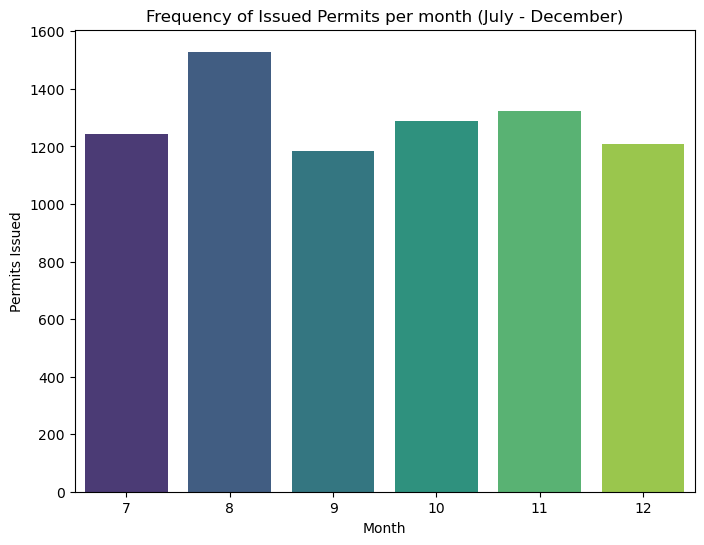

In [7]:
# months permits were issued in 
LA_df['Issue Month'] = LA_df['Issue Date'].dt.month

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Issue Month', data=LA_df, palette='viridis')
plt.title('Frequency of Issued Permits per month (July - December)')
plt.xlabel('Month')
plt.ylabel('Permits Issued')
plt.show()

In [8]:
LA_df['Status'].value_counts()

Permit Finaled        3572
CofO Issued           2734
Issued                1261
Permit Expired          58
Refund Completed        44
CofO Corrected          32
Permit Closed           26
Re-Activate Permit      22
CofO in Progress        18
Refund in Progress       4
Permit Withdrawn         4
Intent to Revoke         2
Name: Status, dtype: int64

The bar graph below shows the status for every permit
- most permits are finalized

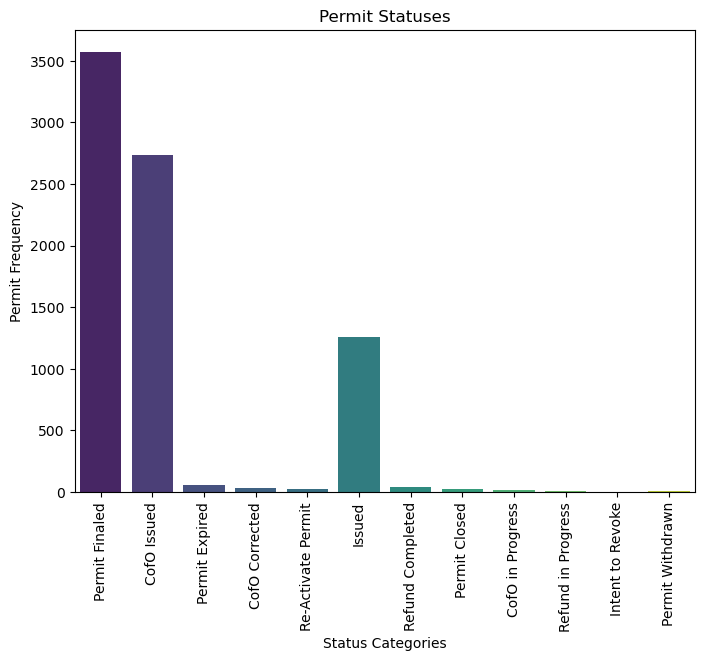

In [9]:
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Status', data=LA_df, palette='viridis')
plt.title('Permit Statuses')
plt.xlabel('Status Categories')
plt.xticks(rotation=90)
plt.ylabel('Permit Frequency')
plt.show()

The graph below shows the frequency of ADU occupancies. An __occupancy__ is the approved use of the structure. 
- most of the recorded occupancies belong in the R3 Occupancy group. 
    - An R3 occupancy group is when residential occupants are primarily permanent in nature and not classified as other Group R occupancies that do not contain more than two dwelling units. --> ADUs are considered to by classified as R3!

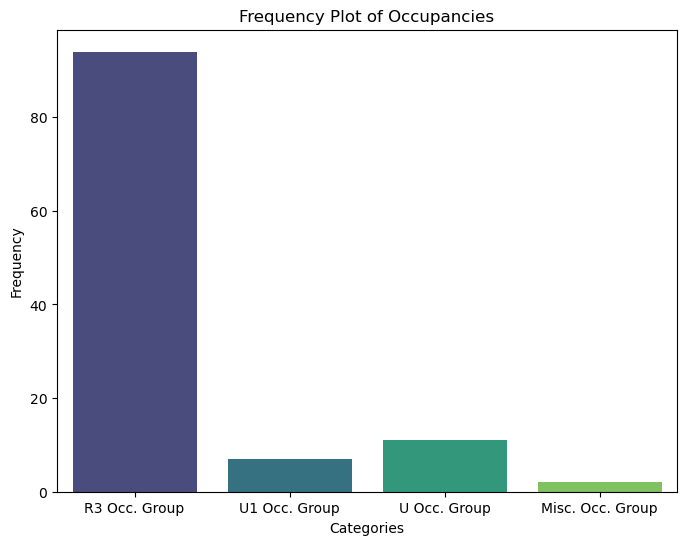

In [10]:
LA_df['Occupancy'].value_counts()

# Create a count plot using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='Occupancy', data=LA_df, palette='viridis')
plt.title('Frequency Plot of Occupancies')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show()

The graph below shows how many permits belong in each permit type category. There are 4 categories
- there are many bldg-alter/repair permit types 
- there are almost no nonbldg-alter/repair permit types 

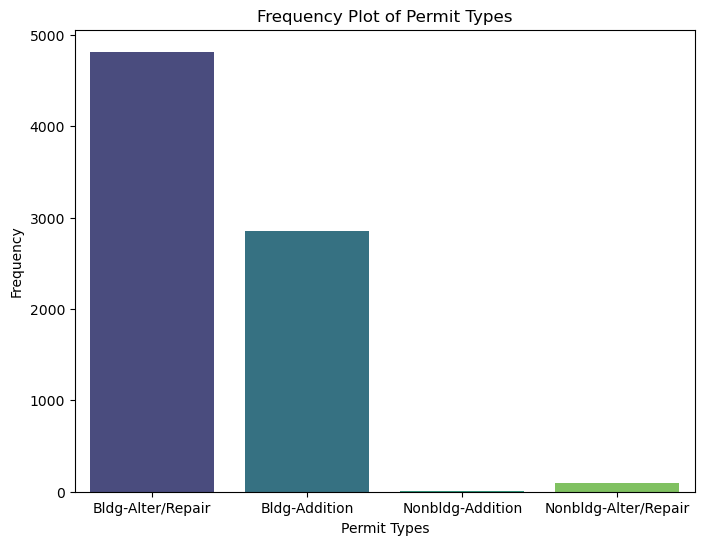

In [11]:
LA_df['Permit Type'].value_counts()

# Create a count plot using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='Permit Type', data=LA_df, palette='viridis')
plt.title('Frequency Plot of Permit Types')
plt.xlabel('Permit Types')
plt.ylabel('Frequency')
plt.show()

> Bivariate plots

These plots put two variables against each other and explore the relationship between the two. 

In [12]:
# finding numeric columns to plot 
numeric_columns = LA_df.select_dtypes(include=['float']).columns
numeric_columns

Index(['Valuation', 'Floor Area-L.A. Zoning Code Definition',
       '# of Residential Dwelling Units', '# of Stories',
       'Floor Area-L.A. Building Code Definition'],
      dtype='object')

The scatterplot below shows the relationship between 'Valuation' and '# of Residential Dwelling Units'. 
- The highest valuations and most valuations go to permits with 0 residential dwelling units, which is a little confusing 
- the second highest, but not even close to the highest, is between 1 and -1 dwelling units
- quesiton: how can there be negative dwelling units??

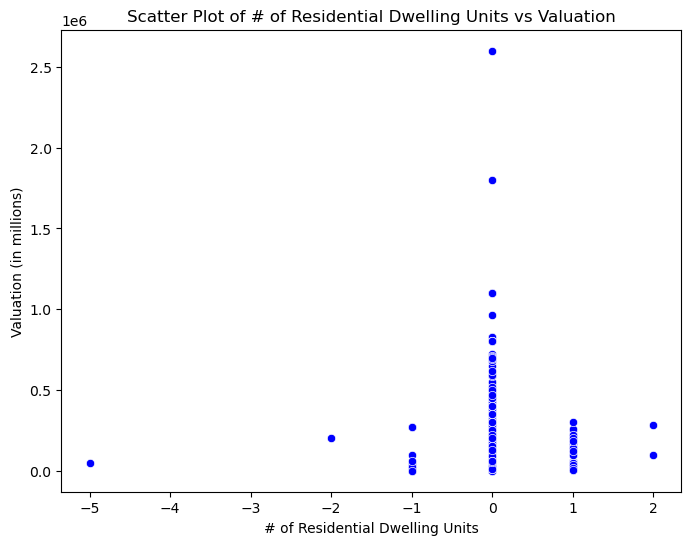

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='# of Residential Dwelling Units', y='Valuation', data=LA_df, color='blue')
plt.title('Scatter Plot of # of Residential Dwelling Units vs Valuation')
plt.xlabel('# of Residential Dwelling Units')
plt.ylabel('Valuation (in millions)')
plt.show()

The scatterplot below shows the relationship between 'Valuation' and '# of Stories'
- 2 stories are the most common with the highest valuation
- 1, 0, 3, 4, 5 are the most common 

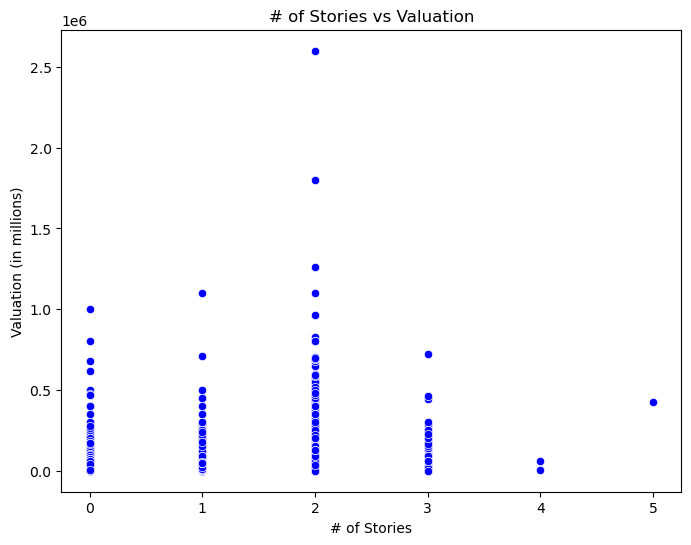

In [14]:


# Create a bar plot using Matplotlib
plt.figure(figsize=(8, 6))
sns.scatterplot(x='# of Stories', y='Valuation', data=LA_df, color='blue')
plt.title('# of Stories vs Valuation')
plt.xlabel('# of Stories')
plt.ylabel('Valuation (in millions)')
plt.show()

The scatterplot below shows the relationship between Floor Area-L.A. Zoning Code Definition & Valuation.
- the regression line shows that as the floor area increases, the valuation increases on average as well
- the confidence interval (light blue area surrounding the line), increases as the floor area increases as well
- most permits have a floor area less than 10,000 and valuation less than $500k

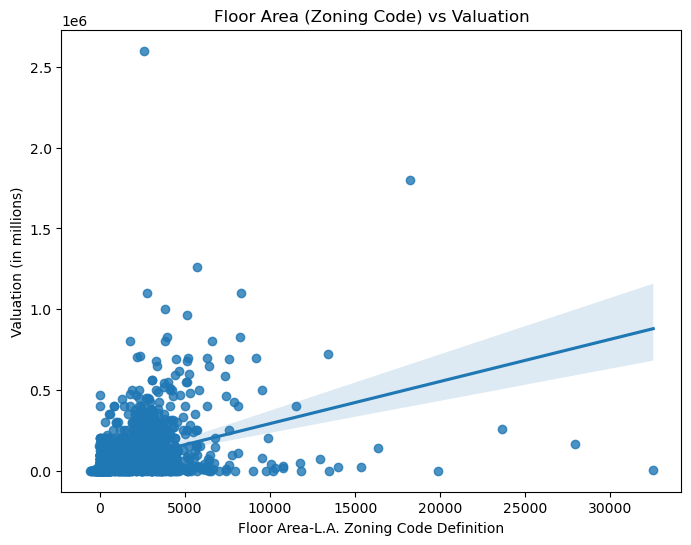

In [15]:
# scatterplot with regression line 

plt.figure(figsize=(8, 6))
# plt.scatter(x=LA_df['Floor Area-L.A. Zoning Code Definition'], y=LA_df['Valuation'])
sns.regplot(x='Floor Area-L.A. Zoning Code Definition', y='Valuation', data=LA_df)
plt.title('Floor Area (Zoning Code) vs Valuation')
plt.xlabel('Floor Area-L.A. Zoning Code Definition')
plt.ylabel('Valuation (in millions)')
plt.show()

The scatterplot below shows the relationship between Floor Area-L.A. Building Code Definition & Valuation.
- the regression line shows that as the floor area increases, the valuation increases on average as well
- the confidence interval (light blue area surrounding the line), increases as the floor area increases as well
- most permits have a floor area less than 4,000 and valuation less than $700k
- there are negative floor areas??

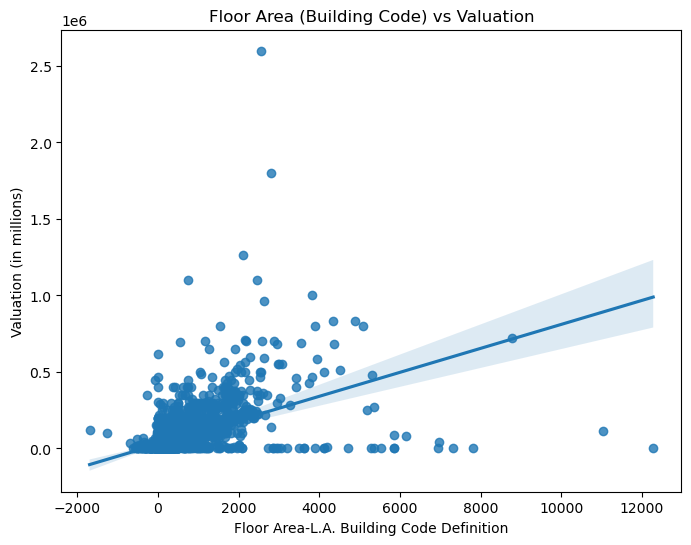

In [16]:
# scatterplot with regression line 

plt.figure(figsize=(8, 6))
sns.regplot(x='Floor Area-L.A. Building Code Definition', y='Valuation', data=LA_df)
plt.title('Floor Area (Building Code) vs Valuation')
plt.xlabel('Floor Area-L.A. Building Code Definition')
plt.ylabel('Valuation (in millions)')
plt.show()

#### Geospatial analysis 

using the longitude and latitute coordinates, we can plot a choropleth map to show which areas in LA had the most dense ADU parts.

> cleaning LA geo 

I want to just get the coordinates of each ADU permit, given in the `Latitude/Longitude` column.   

In [46]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
# will show graphs inside jupyternotebook
%matplotlib inline 

import plotly.express as px
import plotly.graph_objects as go 

#from mlp.toolkits.basemap import Basemap # for custom maps
from geopy.geocoders import Nominatim # turns addresses into coordinates

In [18]:
def lat_long_split(coordinates):

    if pd.isna(coordinates):
        return np.nan
    
    coordinates = coordinates.replace('(', '').replace(')', '') 
    
    # transforming each coordinate from a string to a float
    coordinates_int = []
    for coordinate in coordinates.split(','):
        coordinates_int += [float(coordinate)]

    return coordinates_int

LA_df['coordinates_cleaned'] = LA_df['Latitude/Longitude'].apply(lat_long_split)
LA_df.head()

,Assessor Book,Assessor Page,Assessor Parcel,Tract,PCIS Permit #,Status,Status Date,Permit Type,Permit Sub-Type,Permit Category,...,Applicant Address 2,Applicant Address 3,Zone,Occupancy,Floor Area-L.A. Building Code Definition,Council District,Latitude/Longitude,Applicant Relationship,Issue Month,coordinates_cleaned
0,2556,5,027,TR 5492,17016-30000-23737,Permit Finaled,2017-08-16,Bldg-Alter/Repair,1 or 2 Family Dwelling,Plan Check,...,NaN,NaN,R1-1-RFA,NaN,NaN,7,"(34.26408, -118.31041)",Owner-Bldr,8,"[34.26408, -118.31041]"
1,2565,9,083,P M 6907,17014-20000-01068,CofO Issued,2017-08-15,Bldg-Addition,1 or 2 Family Dwelling,Plan Check,...,NaN,"TUJUNGA, CA",R1-1-RFA,NaN,908.0,7,NaN,Engineer,8,NaN
2,6050,7,007,TR 8359,17014-70000-04720,CofO Issued,2017-11-21,Bldg-Addition,1 or 2 Family Dwelling,Plan Check,...,NaN,NaN,R1-1,NaN,254.6,9,"(33.95181, -118.26178)",Owner,11,"[33.95181, -118.26178]"
3,5434,20,005,IVANHOE,17016-10000-24532,Permit Finaled,2017-08-24,Bldg-Alter/Repair,1 or 2 Family Dwelling,Plan Check,...,NaN,"LOS ANGELES, CA",R1-1,NaN,NaN,4,"(34.1125, -118.27273)",Agent for Owner,8,"[34.1125, -118.27273]"
4,5583,9,002,TR 6450,17016-10001-19079,Permit Finaled,2017-08-29,Bldg-Alter/Repair,1 or 2 Family Dwelling,Plan Check,...,NaN,"LA, CA",R1-1,NaN,NaN,4,"(34.12332, -118.32049)",Agent for Contractor,8,"[34.12332, -118.32049]"


In [19]:
LA_df.columns

Index(['Assessor Book', 'Assessor Page', 'Assessor Parcel', 'Tract',
       'PCIS Permit #', 'Status', 'Status Date', 'Permit Type',
       'Permit Sub-Type', 'Permit Category', 'Initiating Office', 'Issue Date',
       'Address Start', 'Address Fraction Start', 'Address End',
       'Address Fraction End', 'Street Direction', 'Street Name',
       'Street Suffix', 'Suffix Direction', 'Unit Range Start',
       'Unit Range End', 'Zip Code', 'Work Description', 'Valuation',
       'Floor Area-L.A. Zoning Code Definition',
       '# of Residential Dwelling Units', '# of Stories',
       'Contractor's Business Name', 'Contractor Address', 'Contractor City',
       'Contractor State', 'License Type', 'Principal First Name',
       'Principal Middle Name', 'Principal Last Name',
       'License Expiration Date', 'Applicant First Name',
       'Applicant Last Name', 'Applicant Business Name', 'Applicant Address 1',
       'Applicant Address 2', 'Applicant Address 3', 'Zone', 'Occupancy',
   

In [32]:
LA_df['Initiating Office']

0        WEST LA
1       VAN NUYS
2       SOUTH LA
3          METRO
4          METRO
          ...   
7772       METRO
7773       METRO
7774       METRO
7775    VAN NUYS
7776    VAN NUYS
Name: Initiating Office, Length: 7777, dtype: object

In [30]:
import geodatasets

chicago = gpd.read_file(geodatasets.get_path("geoda.Chicago_commpop"))
chicago.head()


,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,38,21929,28006,-6077,-21.698922,0,1,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,39,17841,18363,-522,-2.842673,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [37]:
LA_coordinates = pd.DataFrame()
LA_coordinates[['latitude', 'longitude']] = LA_df['coordinates_cleaned'].apply(pd.Series)
LA_coordinates = LA_coordinates.assign(community = LA_df['Initiating Office'])
LA_coordinates.head()

,latitude,longitude,community
0,34.26408,-118.31041,WEST LA
1,NaN,NaN,VAN NUYS
2,33.95181,-118.26178,SOUTH LA
3,34.11250,-118.27273,METRO
4,34.12332,-118.32049,METRO


In [38]:
# use geopandas to convert
df_geo = gpd.GeoDataFrame(LA_coordinates, geometry = gpd.points_from_xy(LA_coordinates.longitude, LA_coordinates.latitude))
df_geo

,latitude,longitude,community,geometry
0,34.26408,-118.31041,WEST LA,POINT (-118.31041 34.26408)
1,NaN,NaN,VAN NUYS,POINT EMPTY
2,33.95181,-118.26178,SOUTH LA,POINT (-118.26178 33.95181)
3,34.11250,-118.27273,METRO,POINT (-118.27273 34.11250)
4,34.12332,-118.32049,METRO,POINT (-118.32049 34.12332)
...,...,...,...,...
7772,34.09418,-118.27019,METRO,POINT (-118.27019 34.09418)
7773,34.08440,-118.33976,METRO,POINT (-118.33976 34.08440)
7774,33.99676,-118.24898,METRO,POINT (-118.24898 33.99676)
7775,34.24803,-118.55311,VAN NUYS,POINT (-118.55311 34.24803)


<AxesSubplot:>

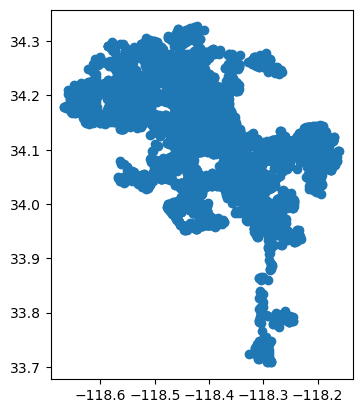

In [39]:
df_geo.plot()

In [45]:
# load world boundaries dataset from geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# filter data to get LA region (you may need to adjust the filter criteria)
la_region = world[world['name'].isin(['United States', 'Mexico'])]

# convert to JSON file

# choropleth map
fig = px.choropleth_mapbox(
    data_frame=df_geo,
    geojson=la_region.geometry,
    locations= None,  # GeoDataFrame column name
    color=None,  
    mapbox_style="carto-positron",  # map style
    center={"lat": 34.0522, "lon": -118.2437},  # centered on LA region
    zoom=10, 
    opacity=0.7,
    labels={'color': 'Your Legend'},
    title='Choropleth Map in LA Region'
)

fig.show()

/var/folders/m4/bgf4hzvx2z9ftfdc9v3p51gw0000gn/T/ipykernel_23734/793929065.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [25]:
import plotly.express as px

df = px.data.election()
geojson = px.data.election_geojson()

fig = px.choropleth(df, geojson=geojson, color="Bergeron",
                    locations="district", featureidkey="properties.district",
                    projection="mercator"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [26]:
# from IPython.display import IFrame
# import folium

# # Example coordinates (San Francisco, New York, and Chicago)
# coordinates = [(37.7749, -122.4194), (40.7128, -74.0060), (41.8781, -87.6298)]

# # Create a map centered at the mean of the coordinates
# map_center = [sum(x[0] for x in coordinates) / len(coordinates),
#               sum(x[1] for x in coordinates) / len(coordinates)]

# m = folium.Map(location=map_center, zoom_start=5)

# # Add markers for each coordinate
# for coord in coordinates:
#     folium.Marker(coord).add_to(m)

# # Save the map
# m.save('map_with_markers.html')

# # Display the map in the notebook using IFrame
# IFrame(src='map_los_angeles_county.html', width=700, height=500)


geospatial analysis of `Initiating Office`, which is where the office location where the permit application is initiated (not necessarily issued).
